# Maximum Diversification Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Result is driven from 2010 to 2021 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import quantstats

from scipy.optimize import minimize

from utils.index_data import index_data
from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import rebalance_strategy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

### Load Data of each representative asset classes data
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]


In [3]:
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'rebal_period':'1D'
}

data = index_data(**data_setting)
yield_df = data.index_data_loading()

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]
# to draw benchmark
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1D',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [4]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

## Optimization Part
#### Maximizing Diversification = Minizing (-Diversification) = Minimizing Concentration
#### If Problem is converted to Minization problem, Optimization is easy (convex)

#### Min/ Max ratio is between 1%, 50%

In [5]:
def MaximumDiversification(asset_ylds):
    lb = 0.01
    ub = 0.5
    covariance_matrix = pd.DataFrame.cov(asset_ylds)


    x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
    lbound  = np.repeat(lb, covariance_matrix.shape[1])
    ubound  = np.repeat(ub, covariance_matrix.shape[1])
    bnds = tuple(zip(lbound, ubound))

    constraints = ({'type': 'ineq', 'fun': minimum_weight},
                   {'type': 'eq', 'fun': sum_weight})
    options = {'ftol': 1e-20, 'maxiter': 1000}

    result = minimize(fun = MaxDivObjective,
                      args=(covariance_matrix),
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    return(result.x)

def MaxDivObjective(x, covariance_matrix):
    # average weighted vol
    x_vol = x.T @ np.sqrt(np.diag(covariance_matrix))
    # portfolio vol. @: matrix multiplication
    variance = x.T @ covariance_matrix @ x
    port_vol = variance ** 0.5

    diversification_ratio = x_vol / port_vol

    return -diversification_ratio

def minimum_weight(x):
    return x

def sum_weight(x):
    return sum(x)-1

In [6]:
rebal_strategy = rebalance_strategy(
    strategy=MaximumDiversification, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=252
)


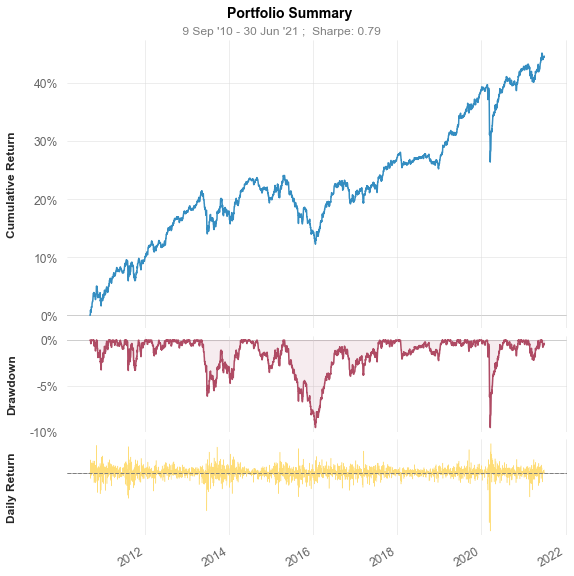

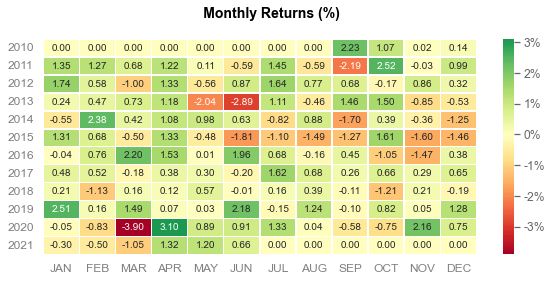

In [7]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

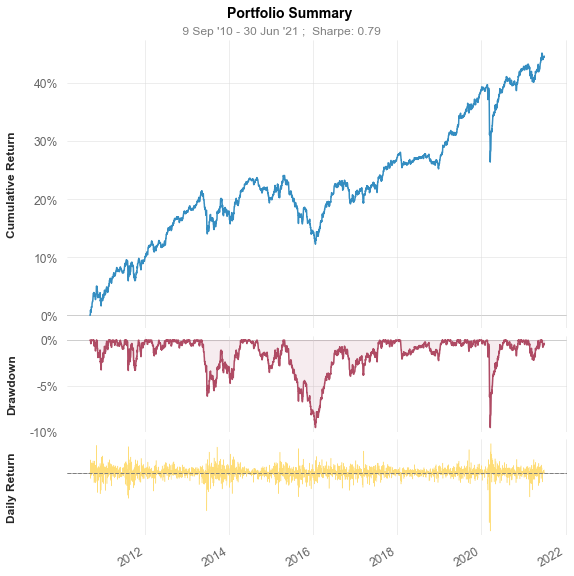

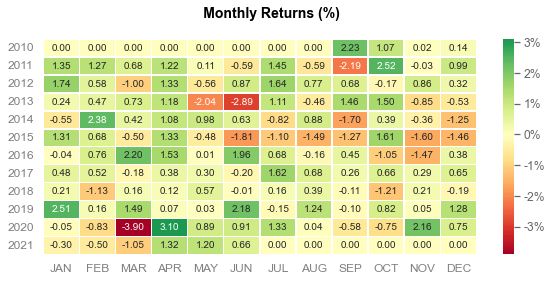

In [8]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-09-10  2010-09-10
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             85.0%       100.0%

Cumulative Return          44.68%      131.41%
CAGR﹪                     3.48%       8.07%

Sharpe                     0.79        0.97
Smart Sharpe               0.72        0.88
Sortino                    1.09        1.36
Smart Sortino              0.99        1.24
Sortino/√2                 0.77        0.96
Smart Sortino/√2           0.7         0.87
Omega                      1.19        1.19

Max Drawdown               -9.54%      -14.1%
Longest DD Days            837         485
Volatility (ann.)          3.04%       5.71%
R^2                        0.64        0.64
Calmar                     0.36        0.57
Skew                       -1.31       -0.98
Kurtosis                   17.12       14

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-21,2020-03-18,2020-07-15,145,-9.542833,-8.163434
2,2015-04-17,2016-01-20,2017-08-01,837,-9.537204,-8.926012
3,2013-05-09,2013-06-25,2014-04-16,342,-6.118471,-5.739345
4,2014-09-02,2014-12-16,2015-04-15,225,-3.520530,-3.147787
5,2011-07-25,2011-08-08,2011-11-07,105,-3.309081,-3.244907


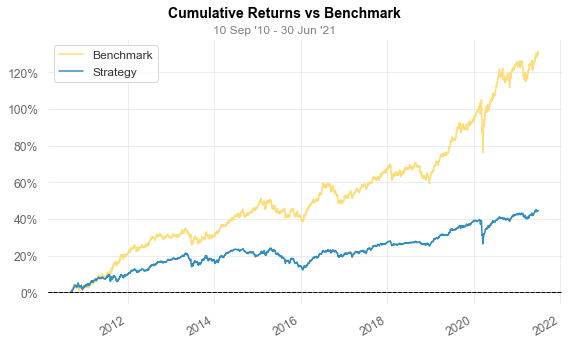

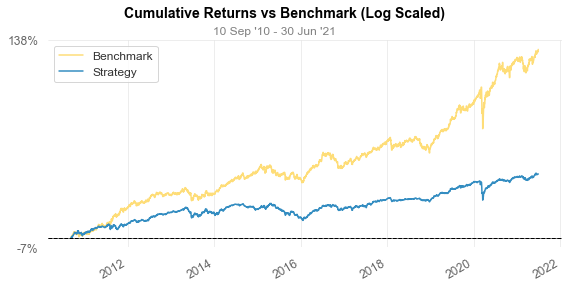

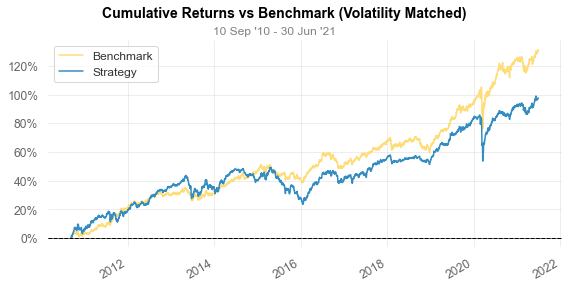

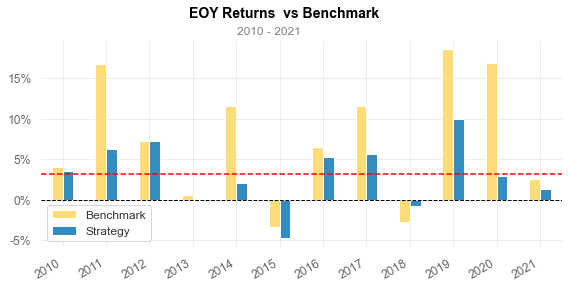

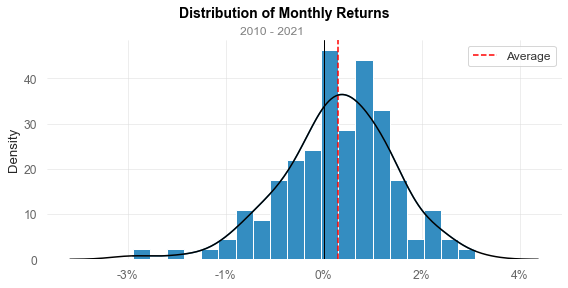

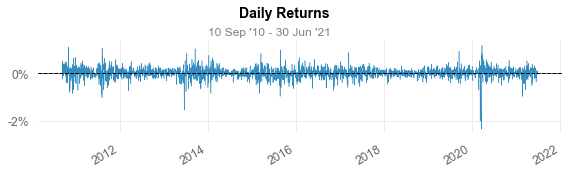

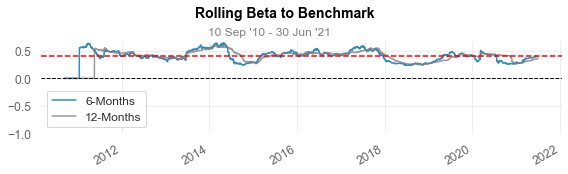

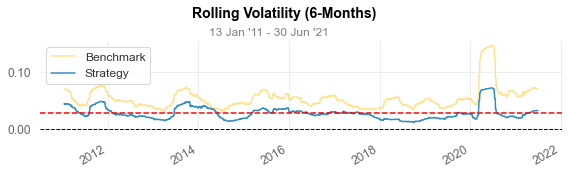

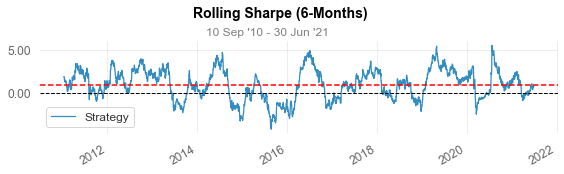

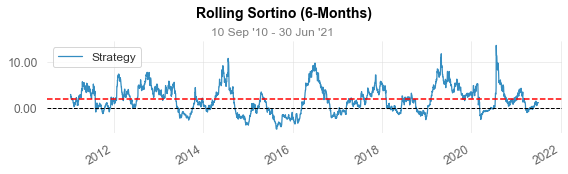

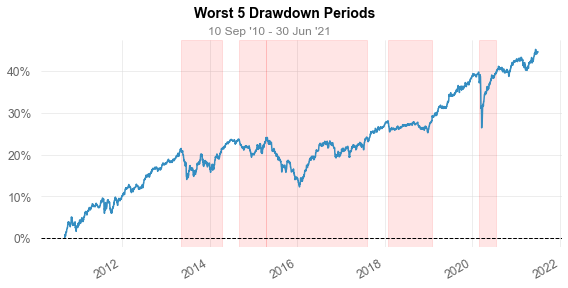

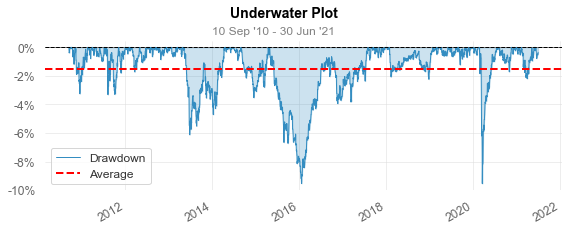

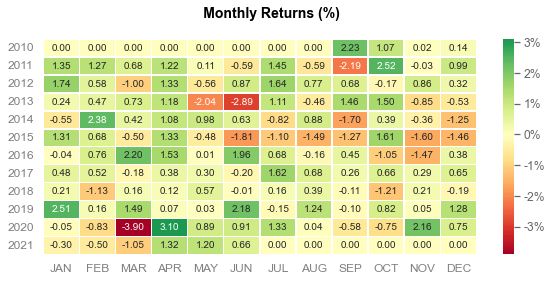

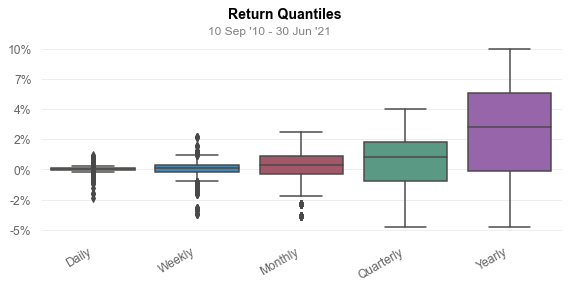

In [9]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)